# Ferguson Climate Calculator

In this notebook the Ferguson family will establish out best understanding of the most critical climate change facts

In [1]:
# First import needed function libraries
from datapackage import Package
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

Perhaps the most central data to the discussion is atmospheric concentration of carbondioxide.  

We can pull in that data from the datahub.io website and convert it to python arrays with the following code.

In [2]:
package = Package('https://datahub.io/core/co2-ppm/datapackage.json')

co2_mm_mlo = package.resources[1]

decimal_year = np.array([
  float(row[1]) 
  for row in co2_mm_mlo.read()
  ])

co_concentration = np.array([
  float(row[2]) 
  for row in co2_mm_mlo.read()
  ])

# Seems to be some weird -100 readings let's eliminate those.
d_year_array = []
co_array = []

for d_year, co in zip(decimal_year, co_concentration):
    if 0 < co:
        d_year_array += [d_year]
        co_array += [co]
        
d_year_array = np.array(d_year_array)
co_array = np.array(co_array)

Next plot the data

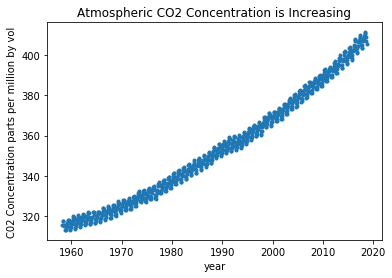

In [3]:
plt.figure()
plt.title('Atmospheric CO2 Concentration is Increasing')
plt.plot(d_year_array, co_array,'.')
plt.xlabel('year')
plt.ylabel('C02 Concentration parts per million by vol')
plt.show()

## Fitting the data

To understand the data lets fit it to the following model function: $co(y)$ 

\begin{align}
co(y) = C \, (1+r)^{\left( y-y_0 \right)} + C_0 + A \cos(2\pi(y-y_s))
\end{align}

For simplicity we shift relative to a reference year which we choose to be 1960: So y0 = 1960.

In [4]:
y0 = 1960

The other parameters in the function will be fit to the data to fine thier optimal values. They are:
- $C_0$ : a baseline concentration of $C0_2$.
- $A$ : the amplitude of seasonal oscilations of $CO_2$ (more trees in northern hemisphere)
- $y_s$: a shift to align the seasons to the proper time of year
- $C$ : the concentration of $CO_2$ due to an additional source in the reference year. 
- $r$ : the growth rate per year for the additional $CO_2$ contribution.

An initial guess for these parameters are

In [5]:
C0 = 240 
A = 4
y_s = .5
C = 40
r = .02

# group these parameters into a list
p0 = [C0 , A, y_s, C, r]

We now define the fit function, and use scipy's curve_fit to find the optimal parameters `p_opt`.

In [6]:
def model_func(dec_year, C0 , A, y_s, C, r):
    out = C0 + C*(1+r)**(dec_year-y0) + A*np.cos(2*np.pi*(dec_year - y_s))
    return out

p_opt, p_cov = curve_fit(model_func, d_year_array, co_array, p0=p0)
# set our parameters to the optimal fit ones
[C0 , A, y_s, C, r] = p_opt

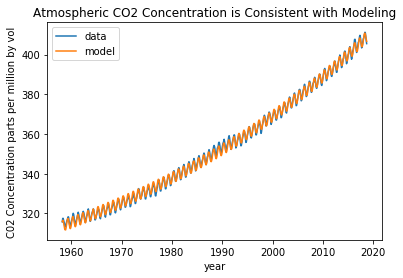

In [9]:
plt.figure()
plt.title('Atmospheric CO2 Concentration is Consistent with Modeling')
plt.plot(d_year_array, co_array, label='data')
plt.plot(d_year_array, model_func(d_year_array, C0 , A, y_s, C, r), label='model')
plt.legend()
plt.xlabel('year')
plt.ylabel('C02 Concentration parts per million by vol')
plt.show()

The formula to calculate the double time from the growth rate is

$ \Delta y = 1/log_2(1+r) $

Our initial conclusions from the data is:

In [8]:
print('Baseline CO concentration is '+str(C0)[0:5]+' parts per million by volume.')
print('Amplitude of seasonal CO concentration oscilations is '+str(A)[0:5]+' parts per million by volume.')
print('CO concentration of additional contribution in 1960 is '+str(C)[0:5]+' parts per million by volume.')
print('Growth rate per year of additional contribution is '+str(100*r)[0:5]+" %")
print('Doubling time of additional contribution is '+str(1/np.log2(1+r))[0:5]+' years.')

Baseline CO concentration is 256.4 parts per million by volume.
Amplitude of seasonal CO concentration oscilations is 2.835 parts per million by volume.
CO concentration of additional contribution in 1960 is 58.85 parts per million by volume.
Growth rate per year of additional contribution is 1.634 %
Doubling time of additional contribution is 42.74 years.
